### This notebook is for the precipitation (pr) and can be used for all variables jut by simply changing the ncvar ###

In [ ]:
# I/O / data wrangling
import glob
import re
import numpy as np
import xcdat as xc
import xarray as xr
import gc

# runtime metrics
import time as clocktime

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

In [3]:
# plotting
import matplotlib.pyplot as plt

In [4]:
def fig_size(W=15,H=5) :

    import matplotlib.pylab as pylab
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (W, H),
             'axes.labelsize': 'xx-large',
             'axes.titlesize':'xx-large',
             'xtick.labelsize':'xx-large',
             'ytick.labelsize':'xx-large'}
    pylab.rcParams.update(params)
    
fig_size(W=15,H=10)

In [5]:
import pandas as pd

In [6]:
# !pip install jupyter-tensorboard
# !pip install cartopy
# !pip install -q -U keras-tuner
# !pip install innvestigate
# !pip install tensorflow-addons

In [7]:
# import keras_tuner as kt
# import tensorflow_addons as tfa

In [8]:
# tensorflow for NN
import tensorflow as tf
import keras

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
# from sklearn.cross_decomposition import PLSRegression
import random
from scipy import stats
import statsmodels.api as sm

In [11]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [12]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [13]:
# root_dir = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/"  # path to forcesmip data (ETH)
root_dir     = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # path to forcesmip data (NCAR)

# n_members = 10  # number of members for training
ncvar = "pr" # variable to be used: pr, psl, tas, zmta, tos, siconc, monmaxpr, monmaxtasmax, monmintasmin
# reference_period = ("1950-01-01", "1999-12-31") # climatological period (for anomaly calculations)
reference_period = ("1980-01-01", "1999-12-31") # climatological period (for anomaly calculations)

# choose models for training / validation
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
# training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR"]
# testing_models = ["MIROC-ES2L"]
# training_models = ["MIROC-ES2L", "CESM2", "CanESM5", "MIROC6"]
# testing_models = ["MPI-ESM1-2-LR"]

training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR", "MIROC-ES2L"]
testing_models  = []

# choose number of members for training / validation
n_members_train = 20
n_members_val   = 4

# MIROC-ES2L (30 members)
# CESM2 (50 members)
# CanESM5 (25 members)
# MIROC6 (50 members)
# MPI-ESM1-2-LR (30 members)


# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3
tv_time_period = evalPeriods[eval_tier]  # populates based on the evaluation data tier, but can be overwritten (with a tuple of date strings)

In [23]:
# training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR"]
# testing_models  = ["MIROC-ES2L"]

training_models = ["CESM2", "CanESM5", "MIROC-ES2L", "MPI-ESM1-2-LR","MIROC6"]
testing_models  = []

all_models      = training_models + testing_models

In [24]:
# moving window calculation : 

Window_size = 10

from numpy.lib.stride_tricks import as_strided

def time_slices(aam, window_size=Window_size):
    # Original shape: (N, T, H, W)
    shape = aam.shape
    new_shape = shape[0], shape[1] - window_size + 1, shape[2], shape[3], window_size
    strides = aam.strides[:4] + (aam.strides[1],)
    
    # Create a strided array of windows along the second dimension (time)
    strided_aam = as_strided(aam, shape=new_shape, strides=strides)
    
    # No need to move axes, as the new array is already in the desired shape.
    return strided_aam


In [25]:
Window_size = 10

def time_slices_obs(aam, window_size = Window_size) :
    # Calculate the running mean along the last dimension
    running_mean_XX = []

    for i in range(aam.shape[0] - window_size + 1):
        running_mean_XX.append(aam[i:i + window_size])

    running_mean_XX = np.array(running_mean_XX) #(32, 10, 72, 144)
    running_mean_XX = np.moveaxis(running_mean_XX, 1, 2) ##(32, 72, 10, 144)
    running_mean_XX = np.moveaxis(running_mean_XX, 2, -1) ##(32, 72, 144, 10)
    
    return running_mean_XX

In [26]:
########################## training/testing NN ##############################

In [27]:
####### tuning #######

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband

class AdvancedUNetHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        inputs = Input(shape=self.input_shape)
        
        # Downsample 1
        c1 = Conv2D(
            hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), 
            hp.Choice('conv_1_kernel', values=[3, 5]), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_1_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(inputs)
        d1 = Dropout(hp.Float('dropout_1_rate', min_value=0.0, max_value=0.5, step=0.1))(c1)
        p1 = MaxPooling2D((2, 2))(d1)
        
        # Downsample 2
        c2 = Conv2D(
            hp.Int('conv_2_filters', min_value=64, max_value=256, step=64), 
            hp.Choice('conv_2_kernel', values=[3, 5]), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_2_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(p1)
        d2 = Dropout(hp.Float('dropout_2_rate', min_value=0.0, max_value=0.5, step=0.1))(c2)
        p2 = MaxPooling2D((2, 2))(d2)
        
        # Bottleneck
        b = Conv2D(
            hp.Int('bottleneck_filters', min_value=128, max_value=512, step=128), 
            (3, 3), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_bottleneck_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(p2)
        
        # Upsample 1
        u1 = UpSampling2D((2, 2))(b)
        concat1 = concatenate([u1, d2])
        c3 = Conv2D(
            hp.Int('conv_3_filters', min_value=64, max_value=256, step=64), 
            (3, 3), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_3_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(concat1)
        
        # Upsample 2
        u2 = UpSampling2D((2, 2))(c3)
        concat2 = concatenate([u2, d1])
        c4 = Conv2D(
            hp.Int('conv_4_filters', min_value=32, max_value=128, step=32), 
            (3, 3), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_4_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(concat2)
        
        # Output layer
        outputs = Conv2D(1, (1, 1), activation='linear')(c4)
        
        model = Model(inputs=[inputs], outputs=[outputs])
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error')
        
        return model


In [29]:
### train a UNET for each month, using the architecture and hyperparameters tuned in code_1.tuning.ipynb.  

YR1, YR2 = 1950, 2100


for mon in np.arange(1,13) :

    print('_____________________',ncvar+'_mon'+str(mon),'_____________________')
    
    members_list = []
    all_data     = []
    
    all_data_trend = []
    
    # loop over models
    models = all_models
    
    for im, model in enumerate(models):
    # for im, model in enumerate(models[1:2]):
        model_data       = []
        model_data_trend = []
        
        # start timer
        stime = clocktime.time()
        # initialize nested dictionary for model data
    
    
        # get model files
        # mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
        mpath = "/".join([root_dir, "Training-Ext", cmipTable[ncvar], ncvar, model])
        mfiles = glob.glob(mpath + "/*.nc")
        # parse file names to get list of model members
        # CESM2 has a non-CMIP naming convention
        if model == "CESM2":
            members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
        else:
            members = [p.split("_")[-1].split(".")[0] for p in mfiles]
        members = sorted(members, key=natsort)
    
        members_list.append(members)
    
        print(mfiles[0])
    
        for n_mem in range(0,len(members)) :
            filename = mfiles[n_mem]
            # print(filename)
            file_xr = xr.open_dataset(filename)[ncvar]           
            file_xr = file_xr.sel(time=file_xr.time.dt.month.isin([mon]))
            file_xr = file_xr.groupby('time.year').mean('time')
            file_xr = file_xr.sel(year=slice(str(YR1)+'-01-01',str(YR2)+'-12-31'))
            model_data.append(file_xr)
    
            # get actual trend map
            ts_3d = file_xr
            nt    = ts_3d.shape[0]
            time  = np.arange(1,nt+1)
            ts_3d = np.reshape(np.array(ts_3d), (nt, nlat*nlon))
            tmap, b = np.polyfit(time, ts_3d, 1)
            tmap *= 10  # to K/decade units
            tmap  = np.reshape(tmap, (nlat, nlon))
            model_data_trend.append(tmap)
    
        all_data.append(xr.concat(model_data, dim='member'))
        all_data_trend.append(model_data_trend)
                
    # print(all_data[0])
    			
    			
    ens_averages       = []
    ens_averages_trend = []
    
    for ds in all_data:
        # Assuming your data variable is named 'data_var', replace 'data_var' with your actual variable name
        ens_mean = ds.mean(dim=['member'])
        # print(ens_mean)
        ens_averages.append(ens_mean)
    
        # get actual trend map
        ts_3d = ens_mean
        nt    = ts_3d.shape[0]
        time  = np.arange(1,nt+1)
        ts_3d = np.reshape(np.array(ts_3d), (nt, nlat*nlon))
        tmap, b = np.polyfit(time, ts_3d, 1)
        tmap *= 10  # to K/decade units
        tmap  = np.reshape(tmap, (nlat, nlon))
        ens_averages_trend.append(tmap)			
    			
    			
    			
    			
    years = np.array(all_data[0].year)
    # print(years)			
    			
    			
    			
    # Randomly shuffle the indices of the models
    model_indices = np.arange(len(ens_averages))
    # np.random.seed(0)
    # np.random.shuffle(model_indices)
    
    # Split indices into 4 for training and 1 for testing
    training_indices = model_indices[:]			
    			
    			
    			
    			
    			
    			
    train_X, train_y = [], []
    
    for n_mod in range(len(training_indices)) :
            print(n_mod, end=' ')
            # train_X.append(training_data_unforced[n_mod]+synthetic_ens_average_all[n_mod,n_syn])
            # train_y.append( [synthetic_ens_average_all[n_mod,n_syn]]*len(members_list[n_mod]) )
        
            train_X.append(all_data[n_mod])
            train_y.append( [(all_data[n_mod]).mean(dim=['member'])]*len(members_list[n_mod]) )
    
    train_X = [item for sublist in train_X for item in sublist]
    train_y = [item for sublist in train_y for item in sublist]
    
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    
    print(train_X.shape, train_y.shape)				
    			
    			
    			
		
    			
    			
    stime = clocktime.time()
    
    train_X = time_slices(train_X)
    train_y = time_slices(train_y)[:,:,:,:,-1]
    
    # print time elapse for model
    etime = clocktime.time()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    
    print(train_X.shape, train_y.shape)			
    			
    			
    					
    			
    train_X = train_X.reshape(-1,72,144,Window_size)
    train_y = train_y.reshape(-1,72,144)
    
    train_X = np.expand_dims(train_X,axis=-1)
    train_y = np.expand_dims(train_y,axis=-1)
    
    print(train_X.shape, train_y.shape)			
    			
    			
    			

    				
    stime = clocktime.time()
    
    # compute X/Y mean / standard deviation
    X_mean = np.nanmean(train_X, axis=0)
    X_std  = np.nanstd(train_X, axis=0)
    
    # normalize
    train_X = (train_X - X_mean) / X_std
    train_X[np.isnan(train_X)] = 0
    
    # print time elapse for model
    etime = clocktime.time()
    print("Time elapsed: " + str(etime - stime) + " seconds")			
    			
    			


    stime = clocktime.time()
    
    # compute X/Y mean / standard deviation
    Y_mean = np.nanmean(train_y, axis=0)
    Y_std  = np.nanstd(train_y, axis=0)
    
    # normalize
    train_y = (train_y - Y_mean) / Y_std
    train_y[np.isnan(train_y)] = 0
    
    # print time elapse for model
    etime = clocktime.time()
    print("Time elapsed: " + str(etime - stime) + " seconds")


    			
    nt  = len(years)
    # print(nt)			
    			
    			
    			
    			
    			
    input_shape = (72, 144, Window_size)  # Example input shape
    hypermodel = AdvancedUNetHyperModel(input_shape=input_shape)
    
    tuner = Hyperband(
        hypermodel,
        objective='val_loss',
        max_epochs=10,
        # directory='/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22c', 
        directory='/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1',
        project_name='unet_tuning_Hyperband',
        max_consecutive_failed_trials=1,
    )
    
    # tuner.search(train_X, train_y, epochs=10, validation_split=0.2, batch_size=1)
    
    # # Calculate the number of samples to select (n% of the data)
    # num_samples = len(train_X)
    # num_samples_to_select = num_samples // 16  # Use integer division to get an integer result
    # random.seed(0)
    # random_indices = np.random.choice(num_samples, num_samples_to_select, replace=False)
    # ens_eval = 0
    # # tuner.search(train_X[random_indices], train_y[random_indices], epochs=10, batch_size=1, validation_data=(test_X[ens_eval], test_y[ens_eval]))
    
    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    			
    					
    			
    			
    model = tuner.hypermodel.build(best_hps)
    if mon==1:
        model.summary()			
    			
    			
    			
    			
    # early stopping tracks the validation loss
    es_train =  tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10, # if loss doesn't decrease for 5 epochs...
                verbose=0,
                mode='auto',
                baseline=None,
                restore_best_weights=True,#... restore the best weights
                start_from_epoch=0
            )
    					
    			
    			
    			
    history = model.fit(
        train_X, train_y,
        validation_split=0.2,  # Use 20% of the data for validation
        epochs=300,  # Start with a few epochs
        batch_size=256,
        callbacks=[es_train]
    )			
    			
    			
    			
    			
    DIR = '/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/'+ncvar+'_mon'+str(mon)+'_trained_model.keras'
    model.save(DIR+'trained_model_all_models.keras')
    			
    			
    				
    pd.DataFrame.from_dict(history.history).to_csv('/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/'+ncvar+'_mon'+str(mon)+'_history_trained_model.csv',index=False)			
    			
    			
    			
    			
    loss     = history.history['loss']
    val_loss = history.history['val_loss']
    epochs   = range(1, len(loss) + 1)
    # 
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # plt.ylim(0.1,0.8)
    
    plt.show()			
    			
    			
    		

In [33]:
### Predictions for evaluation data from the trained models for each month ###

_____________________ pr_mon1 _____________________
0 1 2 3 4 

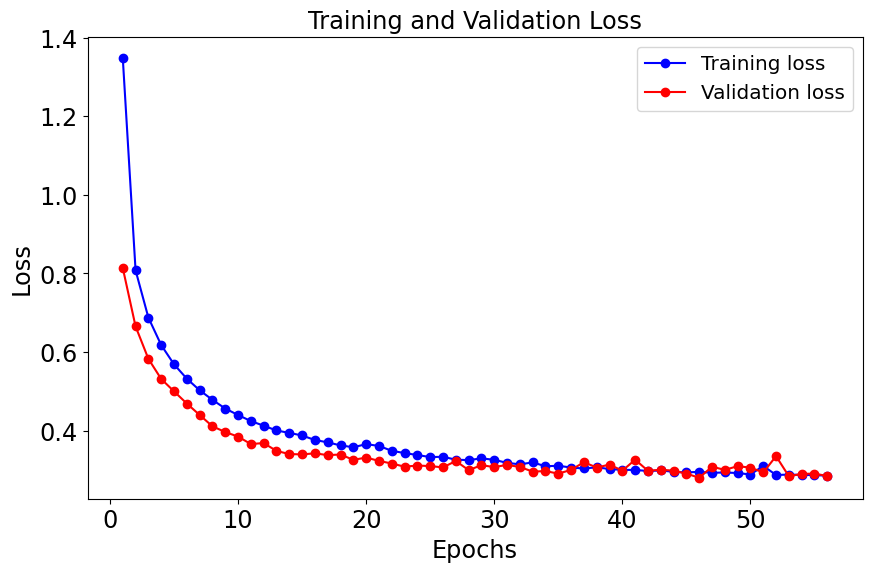

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 2s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

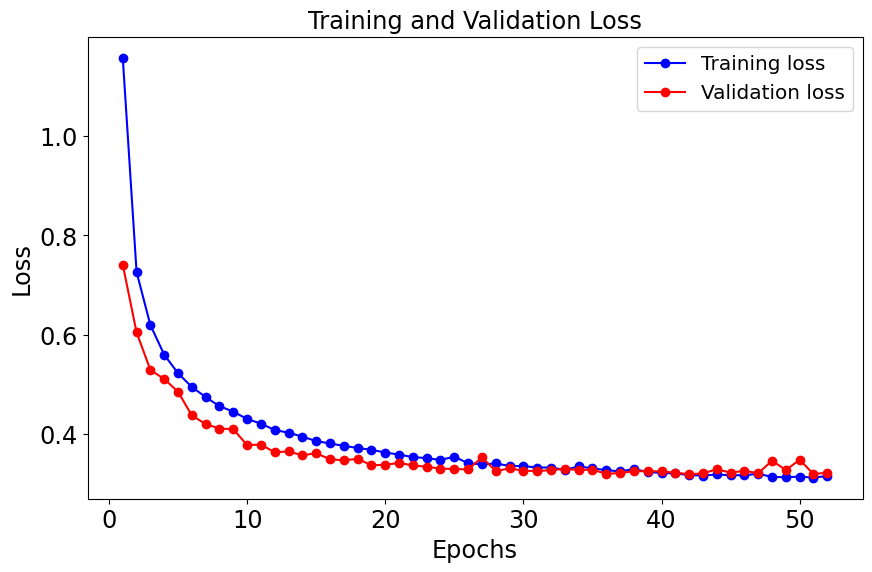

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 4s 2s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

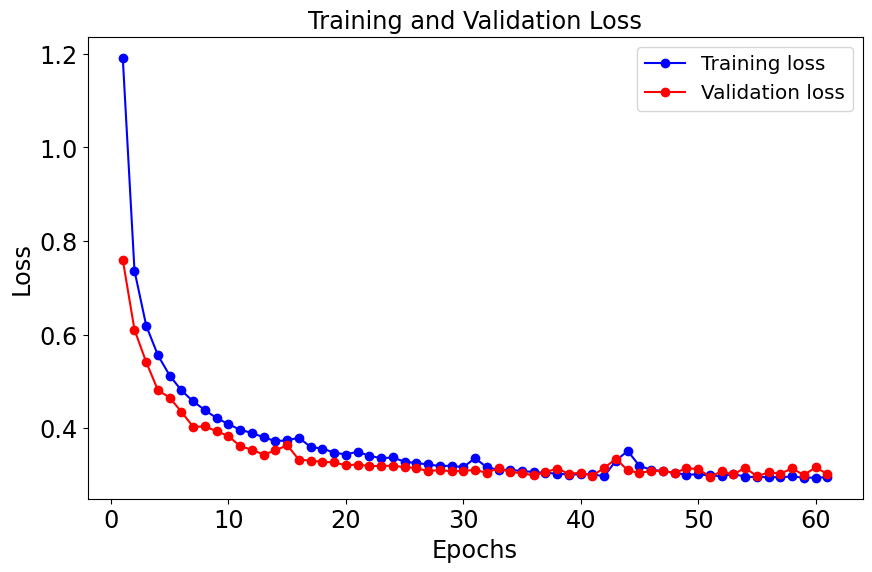

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

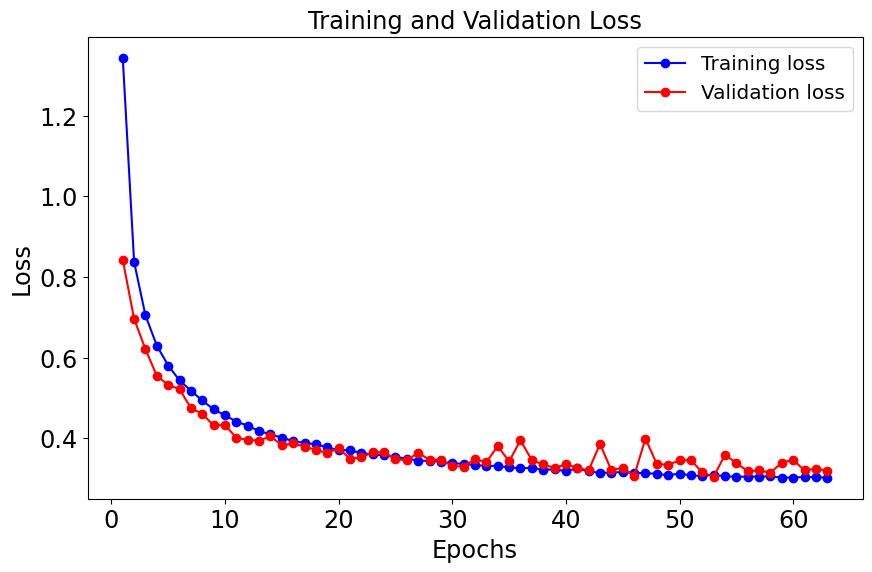

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 4s 2s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 4s 2s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

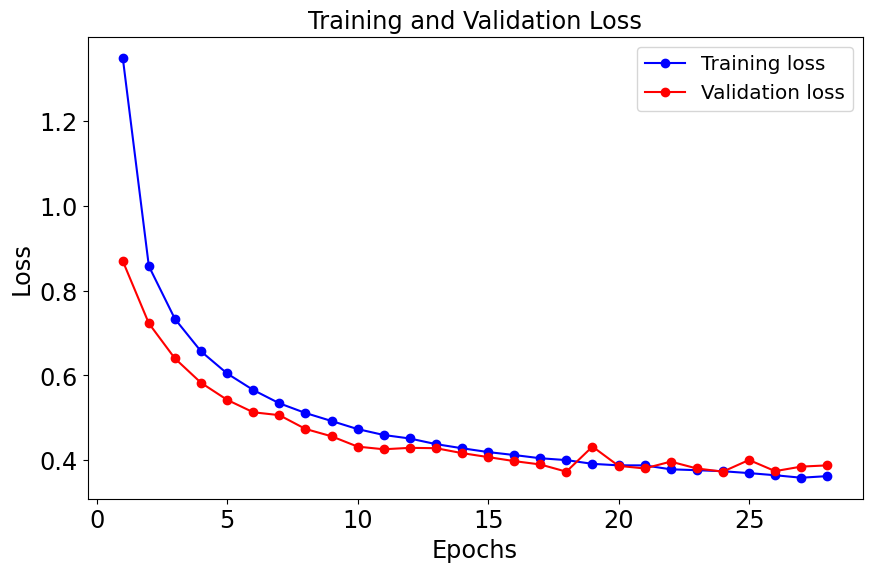

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 2s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 1s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 3s 2s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 4s 2s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 4s 2s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 4s 2s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

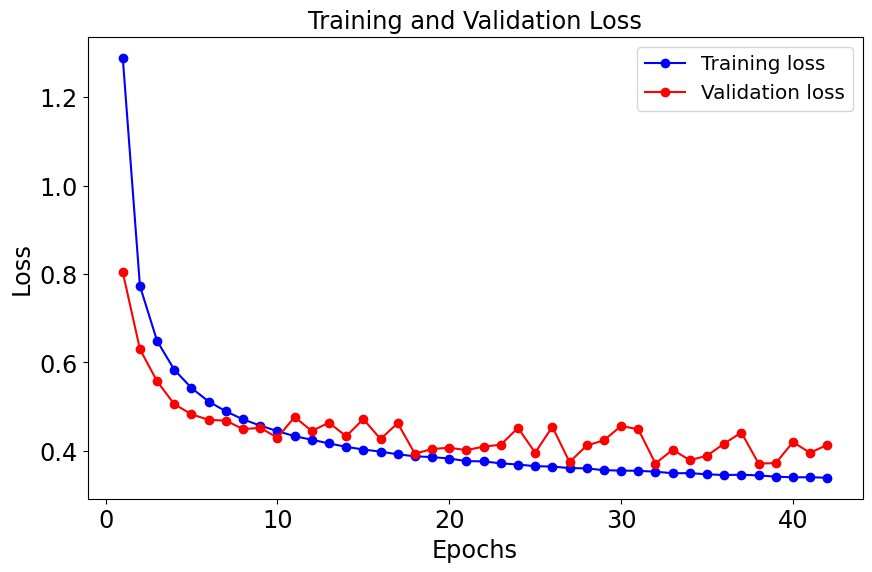

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 3s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 2s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 2s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 2s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 3s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

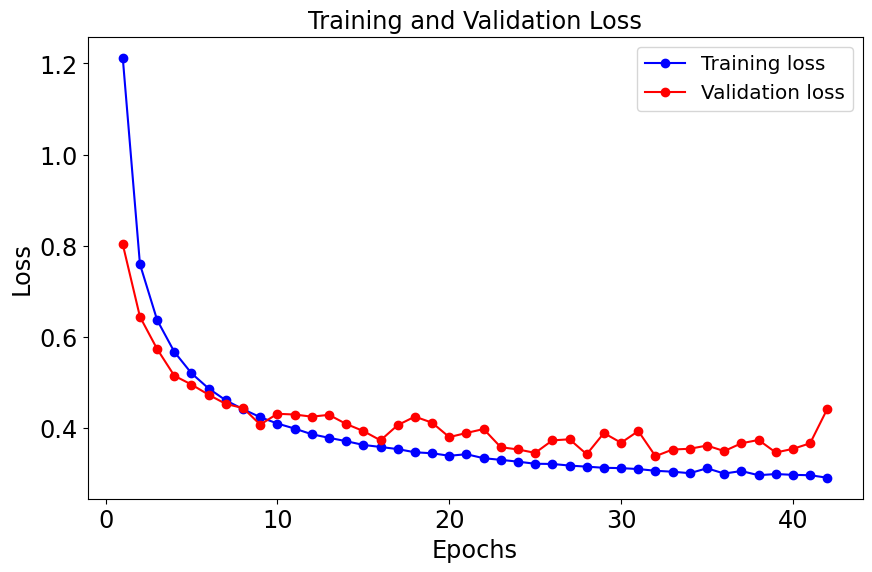

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 4s 2s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 3s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

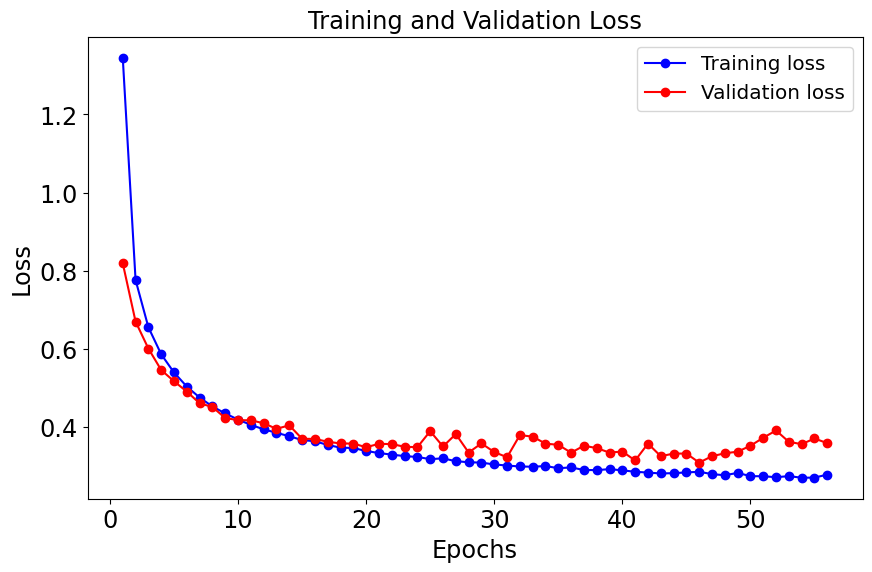

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 2s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 5s 3s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

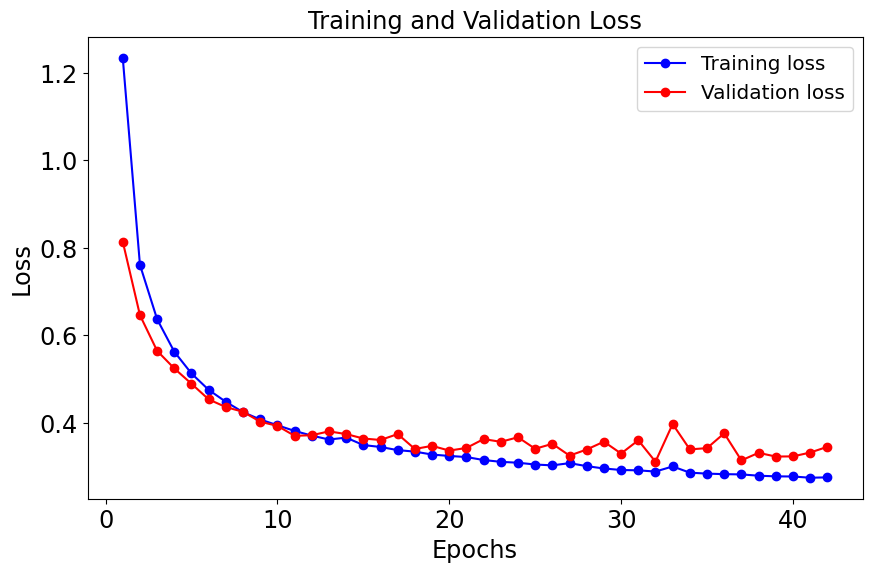

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 8s 3s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

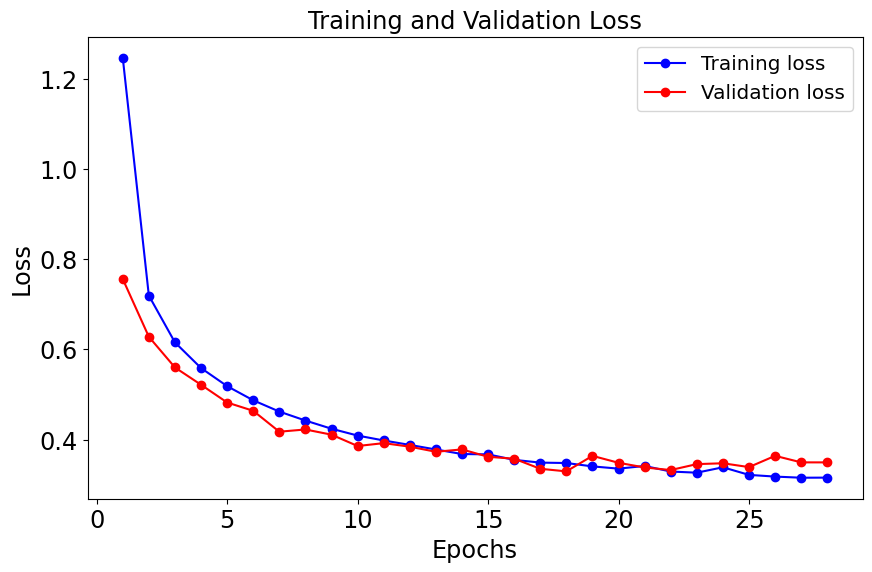

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 4s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 4s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

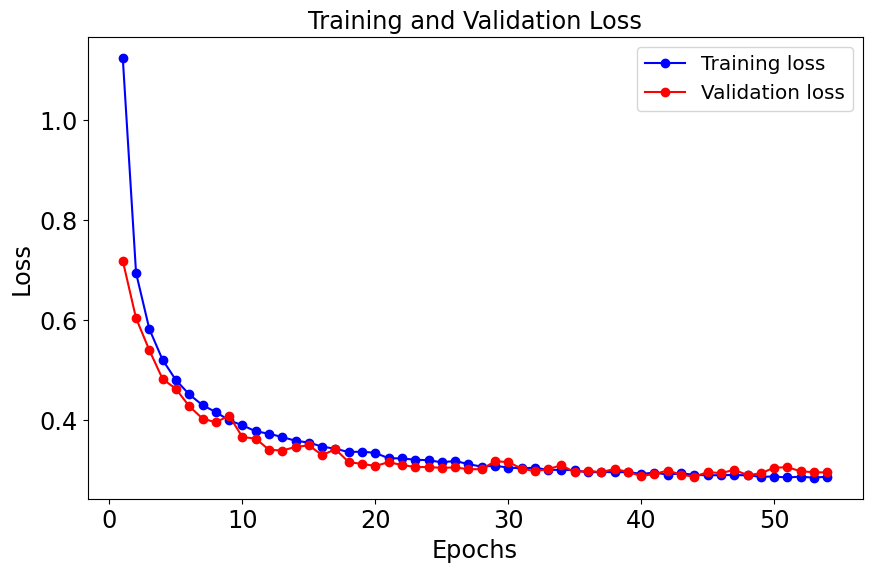

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 8s 3s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 4s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

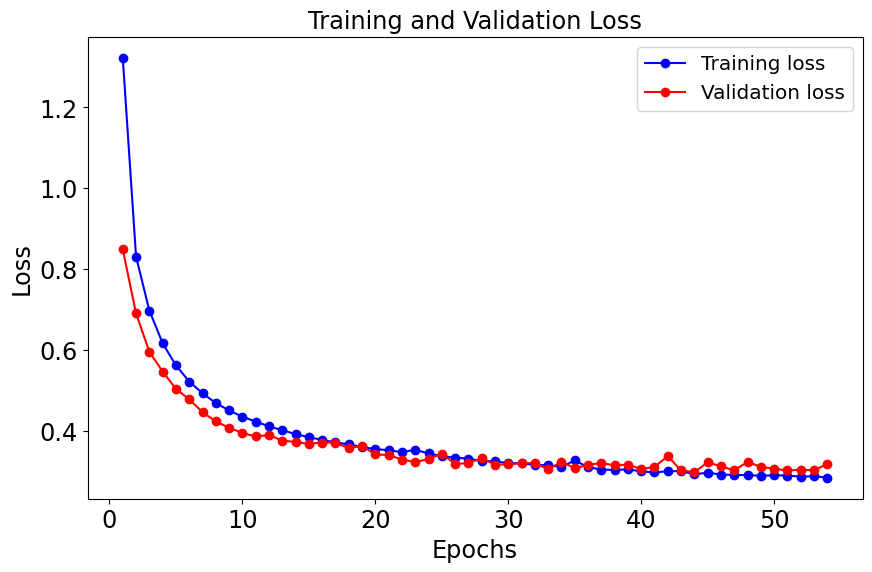

1 / 10: 1A
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 8s 3s/step
(64, 72, 144)
2 / 10: 1B
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 4s/step
(64, 72, 144)
3 / 10: 1C
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
4 / 10: 1D
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 4s/step
(64, 72, 144)
5 / 10: 1E
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
6 / 10: 1F
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 7s 3s/step
(64, 72, 144)
7 / 10: 1G
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
8 / 10: 1H
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] - 6s 3s/step
(64, 72, 144)
9 / 10: 1I
(64, 72, 144, 10)
(64, 72, 144, 10, 1)
2/2 [==============================] -

In [34]:
Window_size = 10

def time_slices_obs(aam, window_size = Window_size) :
    # Calculate the running mean along the last dimension
    running_mean_XX = []

    for i in range(aam.shape[0] - window_size + 1):
        running_mean_XX.append(aam[i:i + window_size])

    running_mean_XX = np.array(running_mean_XX) #(32, 10, 72, 144)
    running_mean_XX = np.moveaxis(running_mean_XX, 1, 2) ##(32, 72, 10, 144)
    running_mean_XX = np.moveaxis(running_mean_XX, 2, -1) ##(32, 72, 144, 10)
    
    return running_mean_XX



YR1, YR2 = 1950, 2100


evaluation_forced = [[]]*12

for mon in np.arange(1,13) :
# for mon in [1] :

    print('_____________________',ncvar+'_mon'+str(mon),'_____________________')
    
    members_list = []
    all_data     = []
    
    all_data_trend = []
    
    # loop over models
    models = all_models
    
    for im, model in enumerate(models):
    # for im, model in enumerate(models[1:2]):
        model_data       = []
        model_data_trend = []
        
        # start timer
        stime = clocktime.time()
        # initialize nested dictionary for model data
    
    
        # get model files
        # mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
        mpath = "/".join([root_dir, "Training-Ext", cmipTable[ncvar], ncvar, model])
        mfiles = glob.glob(mpath + "/*.nc")
        # parse file names to get list of model members
        # CESM2 has a non-CMIP naming convention
        if model == "CESM2":
            members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
        else:
            members = [p.split("_")[-1].split(".")[0] for p in mfiles]
        members = sorted(members, key=natsort)
    
        members_list.append(members)
    
        # print(mfiles[0])
    
        for n_mem in range(0,len(members)) :
            filename = mfiles[n_mem]
            # print(filename)
            file_xr = xr.open_dataset(filename)[ncvar]           
            file_xr = file_xr.sel(time=file_xr.time.dt.month.isin([mon]))
            file_xr = file_xr.groupby('time.year').mean('time')
            file_xr = file_xr.sel(year=slice(str(YR1)+'-01-01',str(YR2)+'-12-31'))
            model_data.append(file_xr)
    
            # get actual trend map
            ts_3d = file_xr
            nt    = ts_3d.shape[0]
            time  = np.arange(1,nt+1)
            ts_3d = np.reshape(np.array(ts_3d), (nt, nlat*nlon))
            tmap, b = np.polyfit(time, ts_3d, 1)
            tmap *= 10  # to K/decade units
            tmap  = np.reshape(tmap, (nlat, nlon))
            model_data_trend.append(tmap)
    
        all_data.append(xr.concat(model_data, dim='member'))
        all_data_trend.append(model_data_trend)
                
    # print(all_data[0])
    			
    			
    ens_averages       = []
    ens_averages_trend = []
    
    for ds in all_data:
        # Assuming your data variable is named 'data_var', replace 'data_var' with your actual variable name
        ens_mean = ds.mean(dim=['member'])
        # print(ens_mean)
        ens_averages.append(ens_mean)
    
        # get actual trend map
        ts_3d = ens_mean
        nt    = ts_3d.shape[0]
        time  = np.arange(1,nt+1)
        ts_3d = np.reshape(np.array(ts_3d), (nt, nlat*nlon))
        tmap, b = np.polyfit(time, ts_3d, 1)
        tmap *= 10  # to K/decade units
        tmap  = np.reshape(tmap, (nlat, nlon))
        ens_averages_trend.append(tmap)			
    			
    			
    			
    			
    years = np.array(all_data[0].year)
    # print(years)			
    			
    			
    			
    # Randomly shuffle the indices of the models
    model_indices = np.arange(len(ens_averages))
    # np.random.seed(0)
    # np.random.shuffle(model_indices)
    
    # Split indices into 4 for training and 1 for testing
    training_indices = model_indices[:]			
    			
    			
    			
    			
    			
    			
    train_X, train_y = [], []
    
    for n_mod in range(len(training_indices)) :
            print(n_mod, end=' ')
            # train_X.append(training_data_unforced[n_mod]+synthetic_ens_average_all[n_mod,n_syn])
            # train_y.append( [synthetic_ens_average_all[n_mod,n_syn]]*len(members_list[n_mod]) )
        
            train_X.append(all_data[n_mod])
            train_y.append( [(all_data[n_mod]).mean(dim=['member'])]*len(members_list[n_mod]) )
    
    train_X = [item for sublist in train_X for item in sublist]
    train_y = [item for sublist in train_y for item in sublist]
    
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    
    # print(train_X.shape, train_y.shape)						
    # (185, 150, 72, 144) (185, 150, 72, 144)

    			
    			
    # stime = clocktime.time()
    
    train_X = time_slices(train_X)
    train_y = time_slices(train_y)[:,:,:,:,-1]
    
    # print time elapse for model
    etime = clocktime.time()
    # print("Time elapsed: " + str(etime - stime) + " seconds")
    
    # print(train_X.shape, train_y.shape)		
    # (185, 141, 72, 144, 10) (185, 141, 72, 144)
    			
    			
    					
    			
    train_X = train_X.reshape(-1,72,144,Window_size)
    train_y = train_y.reshape(-1,72,144)
    
    train_X = np.expand_dims(train_X,axis=-1)
    train_y = np.expand_dims(train_y,axis=-1)
    
    # print(train_X.shape, train_y.shape)	
    # (26085, 72, 144, 10, 1) (26085, 72, 144, 1)
    			
    			
    			

    				
    # stime = clocktime.time()
    
    # compute X/Y mean / standard deviation
    X_mean = np.nanmean(train_X, axis=0)
    X_std  = np.nanstd(train_X, axis=0)
    
    # normalize
    train_X = (train_X - X_mean) / X_std
    train_X[np.isnan(train_X)] = 0
    
    # print time elapse for model
    etime = clocktime.time()
    # print("Time elapsed: " + str(etime - stime) + " seconds")			
    			
    			


    # stime = clocktime.time()
    
    # compute X/Y mean / standard deviation
    Y_mean = np.nanmean(train_y, axis=0)
    Y_std  = np.nanstd(train_y, axis=0)
    
    # normalize
    train_y = (train_y - Y_mean) / Y_std
    train_y[np.isnan(train_y)] = 0
    
    # print time elapse for model
    etime = clocktime.time()
    # print("Time elapsed: " + str(etime - stime) + " seconds")

    train_X = None
    train_y = None


    			

            
    nt  = len(years)
    # print(nt)			
                                
    DIR = '/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/'+ncvar+'_mon'+str(mon)+'_trained_model.keras'
    model = tf.keras.models.load_model(DIR+'trained_model_all_models.keras')
                                    
    history = pd.read_csv('/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/'+ncvar+'_mon'+str(mon)+'_history_trained_model.csv')			
                
    loss     = history['loss']
    val_loss = history['val_loss']
    epochs   = range(1, len(loss) + 1)
    # 
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()	
    
    
    evaluation_pred  = []
    evaluation_names = []
    
    # loop over evaluation files
    for im, fn in enumerate(efiles):
        # get evaluation identifier
        cmodel = fn.split("/")[-1].split("_")[2].split(".")[0]
        # print progress
        print(str(im + 1) + " / " + str(len(efiles)) + ": " + cmodel)
    
        file_xr = xr.open_dataset(fn)[ncvar]           
        file_xr = file_xr.sel(time=file_xr.time.dt.month.isin([mon]))
        file_xr = file_xr.groupby('time.year').mean('time')
        # file_xr = file_xr.sel(year=slice(str(YR1)+'-01-01',str(YR2)+'-12-31'))
        test_X  = np.array(file_xr)
    
    
    
        test_X = time_slices_obs(test_X)
        print(test_X.shape)		
        # (185, 141, 72, 144, 10) (185, 141, 72, 144)
                    
        test_X = test_X.reshape(-1,72,144,Window_size)        
        test_X = np.expand_dims(test_X,axis=-1)
        print(test_X.shape)	
        # (26085, 72, 144, 10, 1) (26085, 72, 144, 1)
                
        # normalize
        test_X = (test_X - X_mean) / X_std
        test_X[np.isnan(test_X)] = 0
        
    
        test_y_pred_ens = model.predict(test_X)[:,:,:,0]
        print(test_y_pred_ens.shape)

        test_y_pred_ens_rescaled = (test_y_pred_ens*Y_std[:,:,0])+Y_mean[:,:,0]
    
        years       = np.array(file_xr.year[Window_size-1:])
        month_dates = [pd.Timestamp(year=year, month=mon, day=1) for year in years]
        data_array  = xr.DataArray(test_y_pred_ens_rescaled, coords=[month_dates, file_xr.lat, file_xr.lon], dims=["time", "lat", "lon"])
        data_array.to_netcdf('/glade/work/gavinmad/forcesmip/notebooks/Gavin/saved/submit/monthly/'+ncvar+'.'+cmodel+'_mon'+str(mon)+'.UNET.TheFingerprinters.nc')
    

In [144]:
# combining monthly forced components and saving final results. 
for im, fn in enumerate(efiles):
    # get evaluation identifier
    cmodel = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + cmodel)

    if im==0 :
        file_xr = xr.open_dataset(fn)[ncvar] 
        time_final = file_xr.time[(Window_size-1)*12:]
    
    test_xr_M = np.zeros((len(years),12,72,144))
    for mon in np.arange(1,13) :
        test_xr_M_mon = xr.open_mfdataset('/glade/work/gavinmad/forcesmip/notebooks/Gavin/saved/submit/monthly/'+ncvar+'.'+cmodel+'_mon'+str(mon)+'.UNET.TheFingerprinters.nc')
        test_xr_M_mon = np.array(test_xr_M_mon['__xarray_dataarray_variable__'])
        test_xr_M[:,mon-1] = test_xr_M_mon - np.nanmean(test_xr_M_mon,axis=0)
        
    test_xr_M   = test_xr_M.reshape(len(years)*12,72,144)
    data_array  = xr.DataArray(test_xr_M, coords=[time_final, file_xr.lat, file_xr.lon], dims=["time", "lat", "lon"])
    dataset     = data_array.to_dataset(name='forced_component')
    
    output_path = f'/glade/work/gavinmad/forcesmip/notebooks/Gavin/saved/submit/final/{ncvar}_{cmodel}_Tier1_3dUNET_TheFingerprinters.nc'  #$VARIABLE_$MEMBERID_$TIER_$METHOD_$GROUPNAME.nc

    dataset.to_netcdf(output_path)

1 / 10: 1A
2 / 10: 1B
3 / 10: 1C
4 / 10: 1D
5 / 10: 1E
6 / 10: 1F
7 / 10: 1G
8 / 10: 1H
9 / 10: 1I
10 / 10: 1J
